# core

> Some utility functions for working with 🤗 diffusers

In [ ]:
#| default_exp core

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# Import necessary modules from the standard library
from pathlib import Path  # For working with file paths

from PIL import Image  # For working with images

import torch  # PyTorch module for deep learning
from torchvision import transforms  # PyTorch module for image transformations

# Import diffusers AutoencoderKL
from diffusers import AutoencoderKL

from diffusers import DDIMScheduler

In [ ]:
#| export
def pil_to_latent(image:'Image', # The image to be converted to latents.
                  vae:'AutoencoderKL' # The VAE model used to convert the image to latents.
                 ):
    """
    This function converts an image to latents using a VAE model.
    
    Returns:
    latents (torch.Tensor): The latents generated from the image.
    """
    
    # Convert the image to a tensor
    img_tensor = transforms.ToTensor()(image)[None]
    
    # Normalize the tensor
    img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())*2 - 1
    
    # Move the tensor to the correct device and type
    img_tensor = img_tensor.to(vae.device).type(vae.dtype)
    
    # Encode the image tensor to latents using the VAE model
    with torch.no_grad():
        latent = vae.encode(img_tensor)
    
    # Return the latents
    return 0.18215 * latent.latent_dist.sample()

**Select a model**

In [ ]:
model_name = "stabilityai/stable-diffusion-2-1"

**Load autoencoder**

In [ ]:
vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae")

**Open sample image**

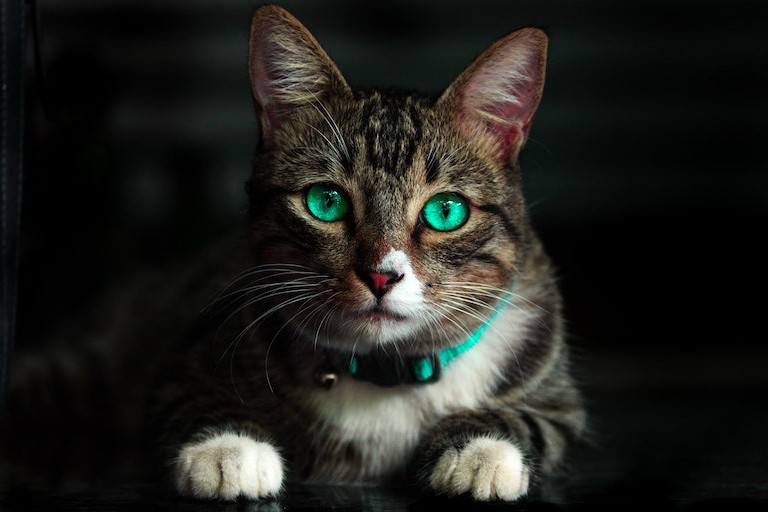

In [ ]:
img_path = '../images/cat.jpg'
src_img = Image.open(img_path).convert('RGB')
src_img

**Encode image**

In [ ]:
img_latents = pil_to_latent(src_img, vae)
img_latents.shape

torch.Size([1, 4, 64, 96])

In [ ]:
#| export
def latent_to_pil(latents:'torch.Tensor', # The latents to be converted to an image.
                  vae:'AutoencoderKL' # The VAE model used to convert the latents to an image.
                 ):
    """
    This function converts latents to an image using a VAE model.
    
    Returns:
    image (PIL.Image): The image generated from the latents.
    """
    
    # Decode the latents using the VAE model
    with torch.no_grad(): 
        img_tensor = vae.decode(1 / 0.18215 * latents).sample.squeeze()
    
    # Convert the tensor to a numpy array
    image = (img_tensor/2+0.5).clamp(0,1).detach().cpu().permute(1, 2, 0).numpy()

    # Convert the numpy array to a PIL image
    return Image.fromarray((image*255).round().astype("uint8"))

**Decode latents**

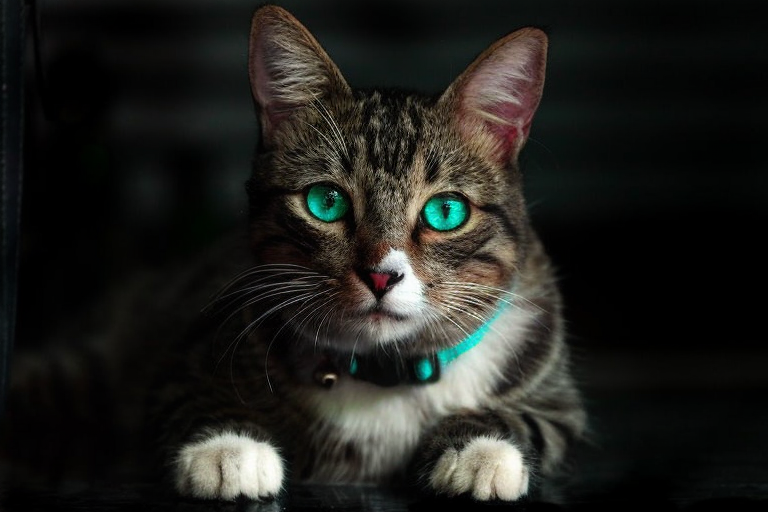

In [ ]:
decoded_img = latent_to_pil(img_latents, vae)
decoded_img

In [ ]:
#| export
# Import the `CLIPTextModel`, `CLIPTokenizer`
from transformers import CLIPTextModel, CLIPTokenizer

In [ ]:
#| export
def text_to_emb(prompt:str, # The text prompt to be encoded.
                tokenizer:CLIPTokenizer, # The tokenizer to be used.
                text_encoder:CLIPTextModel, # The text encoder to be used.
                negative_prompt:str="", # The negative text prompt to be encoded.
                maxlen:int=None # The maximum length of the encoded text. Default is None.
               ):
    """Encodes the provided text prompts using the specified text encoder.
    
    Returns:
        torch.Tensor: The encoded text.
    """
    
    # Set the maximum length to the maximum length supported by the tokenizer if not specified
    if maxlen is None: maxlen = tokenizer.model_max_length
        
    # Tokenize the prompts
    inp = tokenizer(
        [negative_prompt, prompt],
        padding="max_length",
        max_length=maxlen,
        truncation=True,
        return_tensors="pt",
    )
    
    # Move the input IDs to the device used by the text encoder
    input_ids = inp.input_ids.to(text_encoder.device)
    
    # Encode the text using the specified text encoder
    return text_encoder(input_ids)[0]

**Load tokenizer**

In [ ]:
# Load the tokenizer for the specified model
tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")

**Load text encoder**

In [ ]:
# Load the text encoder for the specified model
text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder")

**Define sample prompt**

In [ ]:
prompt = "A cat sitting on the floor."

**Encode sample prompt**

In [ ]:
text_emb = text_to_emb(prompt, tokenizer, text_encoder)
text_emb.shape

torch.Size([2, 77, 1024])

In [ ]:
#| export
def prepare_noise_scheduler(noise_scheduler, # The noise scheduler object to be modified
                            max_steps:int=50, # The maximum number of steps
                            noise_strength:float=1.0 # The strength of the noise
                           ):
    
    """
    Prepare the noise scheduler by setting the timesteps and adjusting the noise strength.
    
    Returns:
    noise_scheduler (object): The modified noise scheduler object
    """
    
    # Initialize the timestep by calculating the maximum number of steps minus the minimum value between
    # the product of max_steps and noise_strength and max_steps
    init_timestep = max(max_steps - min(int(max_steps * noise_strength), max_steps), 0)
    
    # Set the timesteps of the noise scheduler to the max_steps
    noise_scheduler.set_timesteps(max_steps)

    # Assign the remaining timesteps to the noise scheduler
    noise_scheduler.timesteps = noise_scheduler.timesteps[init_timestep:]
    
    # Return the modified noise scheduler
    return noise_scheduler

**Load noise scheduler**

In [ ]:
noise_scheduler = DDIMScheduler.from_pretrained(model_name, subfolder='scheduler')

print(f"Number of timesteps: {len(noise_scheduler.timesteps)}")
noise_scheduler.timesteps[:10]

Number of timesteps: 1000


tensor([999, 998, 997, 996, 995, 994, 993, 992, 991, 990])

**Update noise scheduler**

In [ ]:
noise_scheduler = prepare_noise_scheduler(noise_scheduler, 70, 1.0)

print(f"Number of timesteps: {len(noise_scheduler.timesteps)}")
noise_scheduler.timesteps[:10]

Number of timesteps: 70


tensor([967, 953, 939, 925, 911, 897, 883, 869, 855, 841])

In [ ]:
#| export
def prepare_depth_mask(depth_map, # The depth map image
                       divisor=8  # The divisor value used to resize the depth map
                      ):
    """
    Prepare the depth mask by resizing and normalizing the depth map.
    
    Returns:
    depth_mask (torch.Tensor): The normalized and resized depth mask
    """
    # Convert the depth map image to grayscale
    depth_mask = depth_map.convert("L")
    
    # Resize the depth map by dividing the width and height by the divisor
    depth_mask = depth_mask.resize([d//divisor for d in depth_map.size], resample=Image.Resampling.NEAREST)
    
    # Convert the image to a tensor and add batch dimension
    depth_mask = transforms.ToTensor()(depth_mask)[None]
    
    # Normalize the depth mask values to a range of -1 to 1
    depth_mask = (depth_mask - depth_mask.min()) / (depth_mask.max() - depth_mask.min())*2 - 1
    
    return depth_mask

**Load depth map**

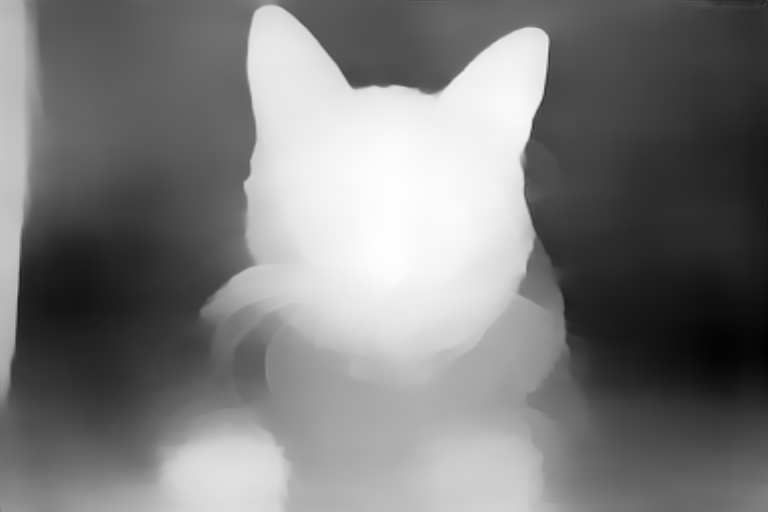

In [ ]:
depth_map_path = '../images/depth-cat.png'
depth_map = Image.open(depth_map_path)
depth_map

**Prepare depth mask**

In [ ]:
depth_mask = prepare_depth_mask(depth_map)
depth_mask.shape, depth_mask.min(), depth_mask.max()

(torch.Size([1, 1, 64, 96]), tensor(-1.), tensor(1.))

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()